# Scrambling of operators

In [1]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra

In [2]:
N  = 21     # Number of spins
J  = 1.0    # ZZ interaction strength
hx = 1.05   # X-field 
hz = 0.5    # Z-field
δt = 0.05   # Time-step for evolution
T  = 5.0    # Total time
χ  = 32;    # Max link dimension allowed

## System

In [3]:
sites = siteinds("S=1/2",N);      # Make N S=1/2 spin indices defining system

In [4]:
# Define mixed-field Ising Hamiltionian operator terms:

H_op = OpSum()
for i=1:N-1
    H_op += 1.0,"Sz",i,"Sz",i+1 # ZZ terms
end
for i=1:N
    H_op +=  hx,"Sx",i         # X terms
    H_op +=  hz,"Sz",i         # Z terms
end
# Convert these terms to an MPO
H = MPO(H_op,sites);

In [5]:
# Perform DMRG to find the ground state:

ψ0 = randomMPS(sites,2)               # Random initial state
sweeps = Sweeps(10)                   # Number of sweeps is 10  
maxdim!(sweeps,10,20,100,100,200)     # Gradually increase states kept
cutoff!(sweeps,1E-10)                 # Desired truncation error
en_min,ψ_gs = dmrg(H,ψ0,sweeps);      # Find the ground state energy 

After sweep 1 energy=-12.18958891073572  maxlinkdim=8 maxerr=6.36E-11 time=13.923


After sweep 2 energy=-12.193513037874741  maxlinkdim=9 maxerr=9.47E-11 time=0.047


After sweep 3 energy=-12.193513446961905  maxlinkdim=5 maxerr=7.46E-11 time=0.063
After sweep 4 energy=-12.193513446963255  maxlinkdim=5 maxerr=4.49E-12 time=0.040


After sweep 5 energy=-12.193513446963276  maxlinkdim=5 maxerr=4.48E-12 time=0.041
After sweep 6 energy=-12.193513446963248  maxlinkdim=5 maxerr=4.48E-12 time=0.055


After sweep 7 energy=-12.193513446963266  maxlinkdim=5 maxerr=4.48E-12 time=0.036
After sweep 8 energy=-12.193513446963252  maxlinkdim=5 maxerr=4.48E-12 time=0.049


After sweep 9 energy=-12.193513446963266  maxlinkdim=5 maxerr=4.48E-12 time=0.036
After sweep 10 energy=-12.19351344696325  maxlinkdim=5 maxerr=4.48E-12 time=0.049


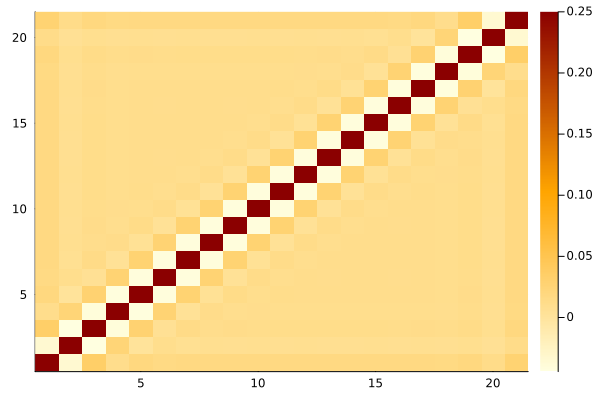

In [6]:
zzcorr = correlation_matrix(ψ_gs,"Sz","Sz");
gr()
heatmap(1:N, 1:N, zzcorr, c = :heat)

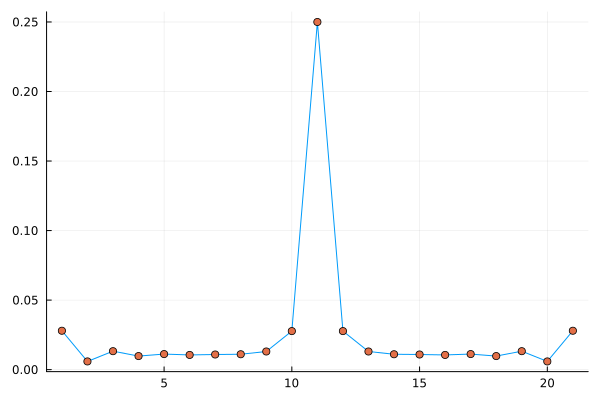

In [7]:
zzcen = diag(reverse(zzcorr, dims = 2));
plot(1:N, zzcen, label=false)  
scatter!(1:N, zzcen, label=false) 

## Extended system + ancilla

In [8]:
sitesext = siteinds("S=1/2",2*N); # Make 2N S=1/2 spin indices defining system + ancilla

In [9]:
# Extract the raising, lowering and identity operators for the extended system:

Sp = ops(sitesext, [("S+", n) for n in 1:(2*N)]);  # Raising operators
Sm = ops(sitesext, [("S-", n) for n in 1:(2*N)]);  # Lowering operators
# ITensors doesn't include the identity operator as standard so construct it:
Id = Vector{ITensor}(undef,2*N)
for i =1:(2*N)
    iv = sitesext[i]
    ID = ITensor(iv', dag(iv));
    for j in 1:ITensors.dim(iv)
        ID[iv' => j, iv => j] = 1.0
    end
    Id[i] = ID
end

In [10]:
# Construct the identity vacuum state:

Ivac = MPS(sitesext, "Up") # All up spins initial state
gates = [(Id[n]*Id[n+1] + Sm[n]*Sm[n+1]) for n in 1:2:(2*N)]; # Maps |00> => |00> + |11>
Ivac = apply(gates, Ivac; cutoff=1e-15); # Note we have no 1/sqrt(2) normalisation

In [11]:
# Vectorisation approach used here is to stack matrix rows into a column vector.
# This means that:
# vec(AB) = A (x) I vec(B) =  I (x) B^T vec(A)
# so |i><j| => |i> (x) |j>
# vec(L A R) = L (x) R^T vec(A)

# Define "Commutator" Hamiltonian operator terms:

# HC = H (x) I - I (x) H, since H is real and hermitian H = H^T.
H_op = OpSum()
for i=1:2*(N-1)
    H_op += (-1)^(i-1) *  J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op += (-1)^(i-1) *  hx,"Sx",i
    H_op += (-1)^(i-1) *  hz,"Sz",i
end
# Convert these terms to an MPO
HC = MPO(H_op,sitesext);

In [12]:
# Define observable for scrambling:

A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, Ivac; cutoff=1e-15);   # Compute |A> = A|I>

## Perform TDVP time evolution of the operator

In [13]:
# Define function for computing entanglement entropy

function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        p = diag(S).^2               # Extract square of Schmidt coefficients
        p = p ./ sum(p)              # Normalise to a probability dist
        SvN[b] = -sum(p .* log2.(p)) # Compute Shannon entropy
    end
    return SvN
end;

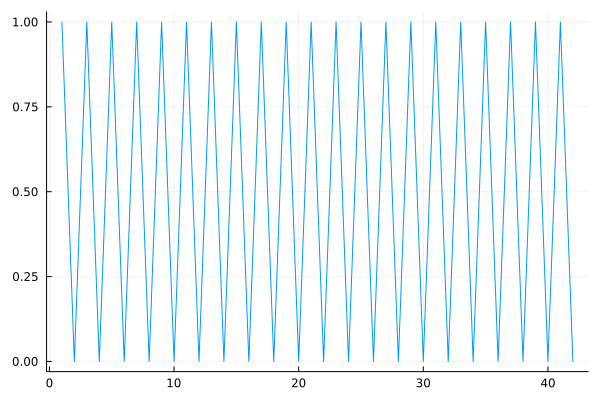

In [14]:
SvN = entanglement_entropy(Avec);
plot(1:(2*N), SvN, label=false) 

Here $|A>$ displays the entanglement structure of the initial vacuum state.

In [15]:
# Define observer functions for TDVP:

function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(-im*current_time)
  end
    
  return nothing
end

function measure_SvN(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return entanglement_entropy(psi)
  end
  return nothing
end;

function measure_linkdim(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return maxlinkdim(psi)
  end
  return nothing
end;

In [16]:
# Perform TDVP evolution of |A(t)>:

obs = Observer("times" => current_time, "SvN" => measure_SvN, "chi" => measure_linkdim)

# d|A(t)>/dt = i HC |A(t)> so |A(t)> = exp(i t HC)|A(0)> 
ψf = tdvp(HC, im * T, Avec; 
          time_step = im * δt,
          normalize = false,
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1,
          (observer!)=obs)

# Extract results from time-step observations
res = results(obs)
times = res["times"]
SvN = res["SvN"]
chi = res["chi"];

After sweep 1: maxlinkdim=2

 maxerr=2.52E-11 current_time=0.0 + 0.05im time=34.975


After sweep 2: maxlinkdim=3 maxerr=9.45E-12 current_time=0.0 + 0.1im time=0.333


After sweep 3: maxlinkdim=3 maxerr=7.57E-11 current_time=0.0 + 0.15im time=0.221


After sweep 4: maxlinkdim=4 maxerr=8.70E-11 current_time=0.0 + 0.2im time=0.211


After sweep 5: maxlinkdim=6 maxerr=6.80E-14 current_time=0.0 + 0.25im time=0.232


After sweep 6: maxlinkdim=6 maxerr=9.75E-14 current_time=0.0 + 0.3im time=0.23


After sweep 7: maxlinkdim=6 maxerr=2.33E-13 current_time=0.0 + 0.35im time=0.224


After sweep 8: maxlinkdim=6 maxerr=9.56E-13 current_time=0.0 + 0.4im time=0.228


After sweep 9: maxlinkdim=6 maxerr=3.23E-12 current_time=0.0 + 0.45im time=0.232


After sweep 10: maxlinkdim=6 maxerr=9.09E-12 current_time=0.0 + 0.5im time=0.234


After sweep 11: maxlinkdim=6 maxerr=2.23E-11 current_time=0.0 + 0.55im time=0.243


After sweep 12: maxlinkdim=6 maxerr=4.92E-11 current_time=0.0 + 0.6im time=0.247


After sweep 13: maxlinkdim=6 maxerr=9.06E-11 current_time=0.0 + 0.65im time=0.242


After sweep 14: maxlinkdim=6 maxerr=9.82E-11 current_time=0.0 + 0.7im time=0.241


After sweep 15: maxlinkdim=6 maxerr=8.69E-11 current_time=0.0 + 0.75im time=0.241


After sweep 16: maxlinkdim=8 maxerr=1.86E-11 current_time=0.0 + 0.8im time=0.239


After sweep 17: maxlinkdim=8 maxerr=3.57E-11 current_time=0.0 + 0.85im time=0.24


After sweep 18: maxlinkdim=8 maxerr=6.62E-11 current_time=0.0 + 0.9im time=0.236


After sweep 19: maxlinkdim=8 maxerr=4.43E-11 current_time=0.0 + 0.95im time=0.239


After sweep 20: maxlinkdim=8 maxerr=8.37E-11 current_time=0.0 + 1.0im time=0.237


After sweep 21: maxlinkdim=8 maxerr=6.59E-11 current_time=0.0 + 1.05im time=0.241


After sweep 22: maxlinkdim=8 maxerr=7.76E-11 current_time=0.0 + 1.1im time=0.252


After sweep 23: maxlinkdim=8 maxerr=7.65E-11 current_time=0.0 + 1.15im time=0.243


After sweep 24: maxlinkdim=8 maxerr=6.16E-11 current_time=0.0 + 1.2im time=0.273


After sweep 25: maxlinkdim=8 maxerr=5.36E-11 current_time=0.0 + 1.25im time=0.255


After sweep 26: maxlinkdim=8 maxerr=9.44E-11 current_time=0.0 + 1.3im time=0.279


After sweep 27: maxlinkdim=8 maxerr=3.51E-11 current_time=0.0 + 1.35im time=0.276


After sweep 28: maxlinkdim=8 maxerr=5.43E-11 current_time=0.0 + 1.4im time=0.266


After sweep 29: maxlinkdim=8 maxerr=8.23E-11 current_time=0.0 + 1.45im time=0.284


After sweep 30: maxlinkdim=8 maxerr=2.74E-11 current_time=0.0 + 1.5im time=0.284


After sweep 31: maxlinkdim=8 maxerr=5.31E-11 current_time=0.0 + 1.55im time=0.272


After sweep 32: maxlinkdim=8 maxerr=9.64E-11 current_time=0.0 + 1.6im time=0.277


After sweep 33: maxlinkdim=8 maxerr=9.23E-11 current_time=0.0 + 1.65im time=0.292


After sweep 34: maxlinkdim=8 maxerr=7.35E-11 current_time=0.0 + 1.7im time=0.292


After sweep 35: maxlinkdim=8 maxerr=9.87E-11 current_time=0.0 + 1.75im time=0.297


After sweep 36: maxlinkdim=8 maxerr=6.17E-11 current_time=0.0 + 1.8im time=0.285


After sweep 37: maxlinkdim=8 maxerr=9.58E-11 current_time=0.0 + 1.85im time=0.289


After sweep 38: maxlinkdim=8 maxerr=9.64E-11 current_time=0.0 + 1.9im time=0.299


After sweep 39: maxlinkdim=9 maxerr=7.60E-11 current_time=0.0 + 1.95im time=0.301


After sweep 40: maxlinkdim=10 maxerr=5.19E-11 current_time=0.0 + 2.0im time=0.309


After sweep 41: maxlinkdim=10 maxerr=7.84E-11 current_time=0.0 + 2.05im time=0.294


After sweep 42: maxlinkdim=10 maxerr=9.41E-11 current_time=0.0 + 2.1im time=0.307


After sweep 43: maxlinkdim=11 maxerr=8.08E-11 current_time=0.0 + 2.15im time=0.316


After sweep 44: maxlinkdim=12 maxerr=7.79E-11 current_time=0.0 + 2.2im time=0.305


After sweep 45: maxlinkdim=12 maxerr=9.37E-11 current_time=0.0 + 2.25im time=0.317


After sweep 46: maxlinkdim=12 maxerr=8.47E-11 current_time=0.0 + 2.3im time=0.312


After sweep 47: maxlinkdim=12 maxerr=9.93E-11 current_time=0.0 + 2.35im time=0.329


After sweep 48: maxlinkdim=13 maxerr=8.33E-11 current_time=0.0 + 2.4im time=0.332


After sweep 49: maxlinkdim=14 maxerr=2.88E-11 current_time=0.0 + 2.45im time=0.332


After sweep 50: maxlinkdim=14 maxerr=4.63E-11 current_time=0.0 + 2.5im time=0.344


After sweep 51: maxlinkdim=14 maxerr=7.29E-11 current_time=0.0 + 2.55im time=0.342


After sweep 52: maxlinkdim=15 maxerr=8.90E-11 current_time=0.0 + 2.6im time=0.336


After sweep 53: maxlinkdim=15 maxerr=4.35E-11 current_time=0.0 + 2.65im time=0.343


After sweep 54: maxlinkdim=15 maxerr=6.34E-11 current_time=0.0 + 2.7im time=0.368


After sweep 55: maxlinkdim=15 maxerr=9.14E-11 current_time=0.0 + 2.75im time=0.354


After sweep 56: maxlinkdim=16 maxerr=7.39E-11 current_time=0.0 + 2.8im time=0.344


After sweep 57: maxlinkdim=16 maxerr=7.50E-11 current_time=0.0 + 2.85im time=0.364


After sweep 58: maxlinkdim=16 maxerr=8.52E-11 current_time=0.0 + 2.9im time=0.358


After sweep 59: maxlinkdim=16 maxerr=9.62E-11 current_time=0.0 + 2.95im time=0.373


After sweep 60: maxlinkdim=16 maxerr=8.02E-11 current_time=0.0 + 3.0im time=0.356


After sweep 61: maxlinkdim=17 maxerr=8.69E-11 current_time=0.0 + 3.05im time=0.37


After sweep 62: maxlinkdim=17 maxerr=8.66E-11 current_time=0.0 + 3.1im time=0.385


After sweep 63: maxlinkdim=18 maxerr=8.95E-11 current_time=0.0 + 3.15im time=0.433


After sweep 64: maxlinkdim=19 maxerr=7.37E-11 current_time=0.0 + 3.2im time=0.411


After sweep 65: maxlinkdim=19 maxerr=8.85E-11 current_time=0.0 + 3.25im time=0.428


After sweep 66: maxlinkdim=20 maxerr=9.91E-11 current_time=0.0 + 3.3im time=0.419


After sweep 67: maxlinkdim=20 maxerr=8.77E-11 current_time=0.0 + 3.35im time=0.445


After sweep 68: maxlinkdim=21 maxerr=7.59E-11 current_time=0.0 + 3.4im time=0.447


After sweep 69: maxlinkdim=21 maxerr=8.85E-11 current_time=0.0 + 3.45im time=0.438


After sweep 70: maxlinkdim=22 maxerr=8.64E-11 current_time=0.0 + 3.5im time=0.451


After sweep 71: maxlinkdim=22 maxerr=6.51E-11 current_time=0.0 + 3.55im time=0.47


After sweep 72: maxlinkdim=22 maxerr=9.03E-11 current_time=0.0 + 3.6im time=0.47


After sweep 73: maxlinkdim=23 maxerr=9.54E-11 current_time=0.0 + 3.65im time=0.473


After sweep 74: maxlinkdim=23 maxerr=8.91E-11 current_time=0.0 + 3.7im time=0.501


After sweep 75: maxlinkdim=24 maxerr=6.84E-11 current_time=0.0 + 3.75im time=0.487


After sweep 76: maxlinkdim=24 maxerr=8.96E-11 current_time=0.0 + 3.8im time=0.504


After sweep 77: maxlinkdim=25 maxerr=9.91E-11 current_time=0.0 + 3.85im time=0.51


After sweep 78: maxlinkdim=25 maxerr=7.97E-11 current_time=0.0 + 3.9im time=0.565


After sweep 79: maxlinkdim=26 maxerr=9.69E-11 current_time=0.0 + 3.95im time=0.527


After sweep 80: maxlinkdim=26 maxerr=9.34E-11 current_time=0.0 + 4.0im time=0.523


After sweep 81: maxlinkdim=26 maxerr=7.88E-11 current_time=0.0 + 4.05im time=0.55


After sweep 82: maxlinkdim=27 maxerr=9.06E-11 current_time=0.0 + 4.1im time=0.563


After sweep 83: maxlinkdim=27 maxerr=8.05E-11 current_time=0.0 + 4.15im time=0.571


After sweep 84: maxlinkdim=27 maxerr=9.66E-11 current_time=0.0 + 4.2im time=0.565


After sweep 85: maxlinkdim=27 maxerr=9.76E-11 current_time=0.0 + 4.25im time=0.561


After sweep 86: maxlinkdim=28 maxerr=9.96E-11 current_time=0.0 + 4.3im time=0.597


After sweep 87: maxlinkdim=29 maxerr=7.81E-11 current_time=0.0 + 4.35im time=0.586


After sweep 88: maxlinkdim=29 maxerr=9.97E-11 current_time=0.0 + 4.4im time=0.598


After sweep 89: maxlinkdim=30 maxerr=9.32E-11 current_time=0.0 + 4.45im time=0.632


After sweep 90: maxlinkdim=30 maxerr=9.56E-11 current_time=0.0 + 4.5im time=0.61


After sweep 91: maxlinkdim=31 maxerr=9.44E-11 current_time=0.0 + 4.55im time=0.647


After sweep 92: maxlinkdim=31 maxerr=9.58E-11 current_time=0.0 + 4.6im time=0.659


After sweep 93: maxlinkdim=32 maxerr=9.75E-11 current_time=0.0 + 4.65im time=0.674


After sweep 94: maxlinkdim=32 maxerr=9.82E-11 current_time=0.0 + 4.7im time=0.669


After sweep 95: maxlinkdim=32 maxerr=1.31E-10 current_time=0.0 + 4.75im time=0.673


After sweep 96: maxlinkdim=32 maxerr=1.74E-10 current_time=0.0 + 4.8im time=0.677


After sweep 97: maxlinkdim=32 maxerr=2.29E-10 current_time=0.0 + 4.85im time=0.706


After sweep 98: maxlinkdim=32 maxerr=2.98E-10 current_time=0.0 + 4.9im time=0.724


After sweep 99: maxlinkdim=32 maxerr=3.85E-10 current_time=0.0 + 4.95im time=0.736


After sweep 100: maxlinkdim=32 maxerr=4.95E-10 current_time=0.0 + 5.0im time=0.762


ErrorException: The syntax `results(observer, "name")` and `results(observer)["name"]` for accessing results from an observer are deprecated. You can access the results of an observer directly with the DataFrames.jl syntax `observer.name` or `observer[!, "name"]`. As of Observers v0.2, observers are just `DataFrame`s from DataFrames.jl. See the [DataFrames documentation](https://dataframes.juliadata.org/stable/) for more details on supported functionality.

In [17]:
# Plot the entanglement entropy of each bond for system + ancilla:
gr()
heatmap(1:(2*N), times, reduce(vcat,transpose.(SvN)), c = :heat)

UndefVarError: UndefVarError: `times` not defined

In [18]:
# Plot the entanglement entropy for bonds separating system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,2:2:(2*N)]
heatmap(1:N, times, S, c = :heat)

BoundsError: BoundsError: attempt to access 42-element Vector{Float64} at index [1:42, 2:2:42]

In [19]:
# Plot entanglement entropy of bonds between system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,1:2:(2*N)]
heatmap(1:N, times, S, c = :heat)

BoundsError: BoundsError: attempt to access 42-element Vector{Float64} at index [1:42, 1:2:41]

In [20]:
# Plot the growth in the maximum link dimension with time:
plot(times, chi, label=false)  
scatter!(times, chi, label=false) 

UndefVarError: UndefVarError: `times` not defined